In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn import metrics
from pyod.models.ecod import ECOD
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
import plotly.express as px

import warnings
warnings.filterwarnings("ignore") 

In [231]:
data = pd.read_csv('marketing_campaign (1).csv',sep = '\t')
pd.set_option('display.max_columns', None)
data

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,43,182,42,118,247,2,9,3,4,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,0,30,0,0,8,7,8,2,5,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,48,217,32,12,24,1,2,3,13,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,30,214,80,30,61,2,6,5,10,3,0,0,0,0,0,0,3,11,0


In [233]:
df = data.copy()

# State, territory, postalcode has lost large amout of data, and hence the reason for dropping them along other columns 
df.drop(['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'Dt_Customer',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'], axis = 1, inplace = True)
df['ID'] = df['ID']
df.dropna(inplace= True)
df.isnull().sum().sort_values(ascending= False).head(2)

df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,5524,1957,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7
1,2174,1954,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5
2,4141,1965,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4
3,6182,1984,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6
4,5324,1981,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5


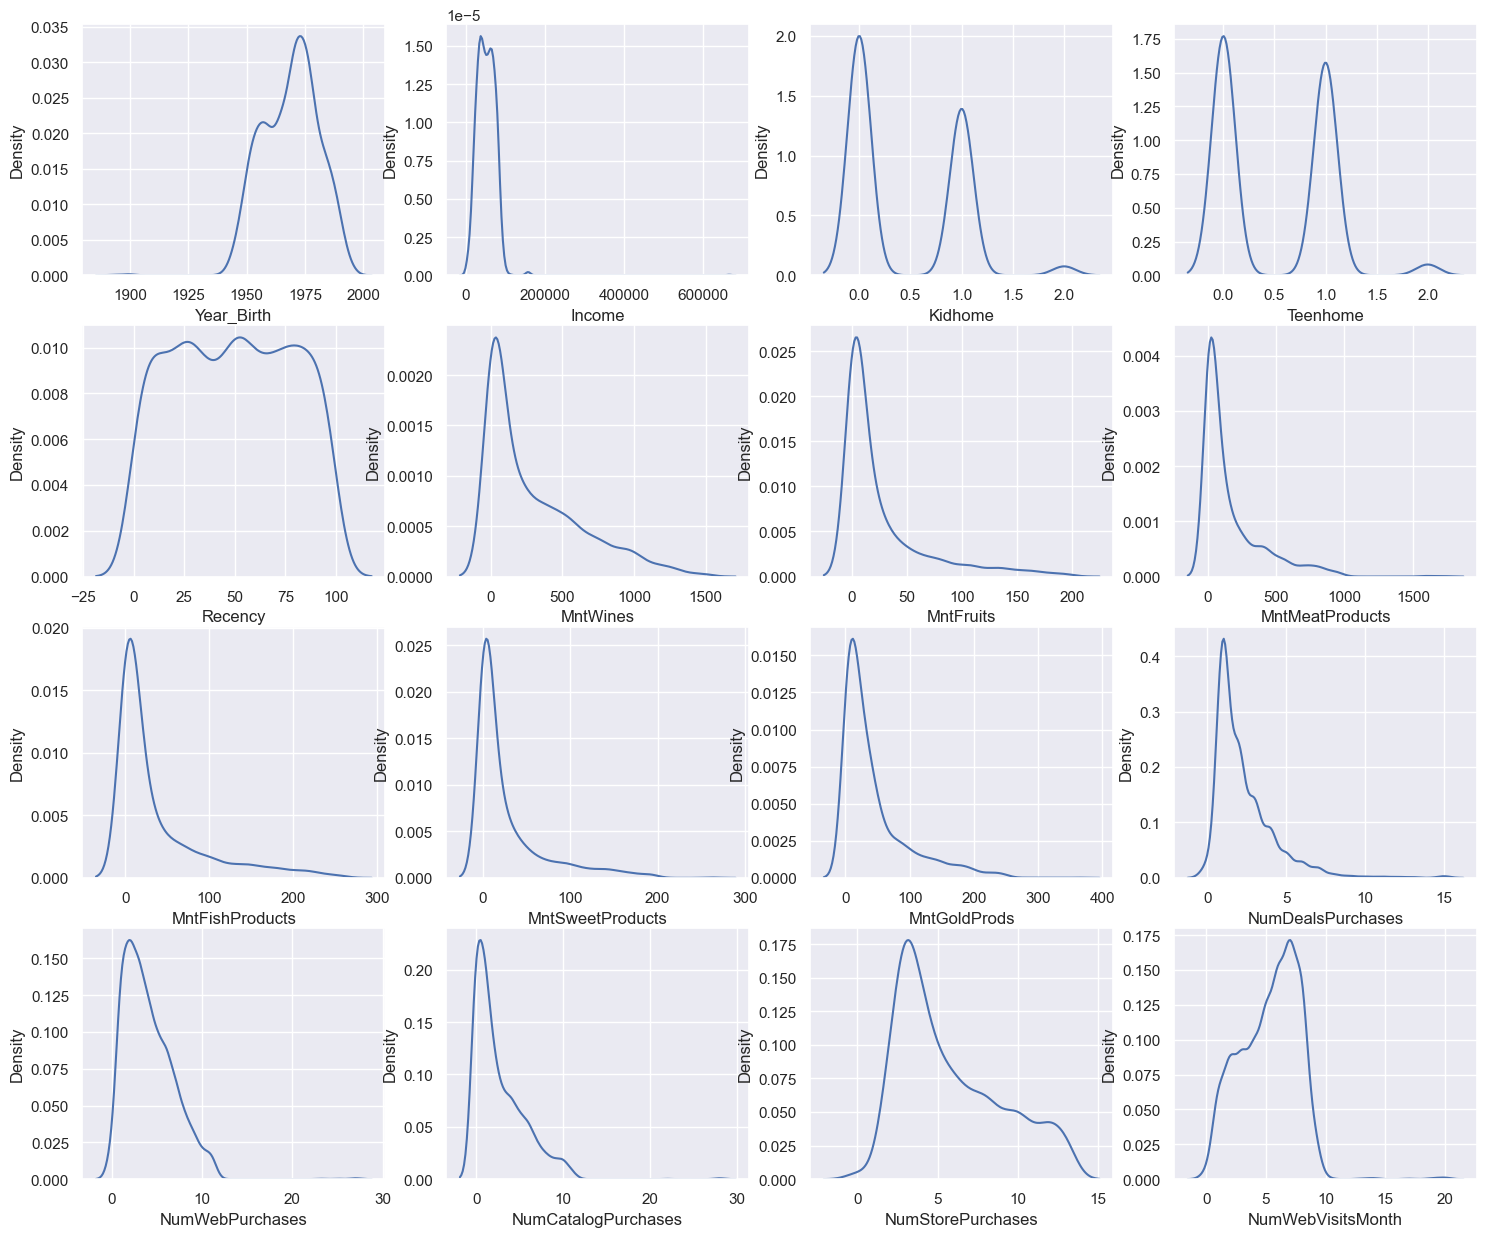

In [10]:
plt.figure(figsize=(18,15))
sns.set(style = 'darkgrid')
for i, col in enumerate(df.select_dtypes(include= 'number').columns):
    if data[col].dtype != 'object':
        ax = plt.subplot(4, 4, i+1)
        sns.kdeplot(data[col], ax=ax)
        plt.xlabel(col)
        

<h3 style = "color:#FF2171"><b><center>Data Transformation</b></h3></center><hr style = "width:400px;text-align:center;color:#EDB7ED">

In [237]:
# Remove Outliers
def outlierRemover(dataframe):
    clf = ECOD()
    clf.fit(dataframe)
    outliers = clf.predict(dataframe) 

    dataframe["outliers"] = outliers
    dataframe = dataframe.loc[dataframe['outliers'] == 0]
    dataframe.drop('outliers', axis = 1, inplace = True)
    print(dataframe.shape)
    return dataframe

removed_outlier = outlierRemover(df.select_dtypes(include='number'))
removed_outlier.reset_index(inplace = True)
removed_outlier

(1994, 17)


,index,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,0,5524,1957,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7
1,1,2174,1954,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5
2,2,4141,1965,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4
3,3,6182,1984,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6
4,4,5324,1981,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,2235,10870,1967,61223.0,0,1,46,709,43,182,42,118,247,2,9,3,4,5
1990,2236,4001,1946,64014.0,2,1,56,406,0,30,0,0,8,7,8,2,5,7
1991,2237,7270,1981,56981.0,0,0,91,908,48,217,32,12,24,1,2,3,13,6
1992,2238,8235,1956,69245.0,0,1,8,428,30,214,80,30,61,2,6,5,10,3


In [238]:
def transform(dataframe):
    # Standard Scaling 
    for i in dataframe.columns:
        if dataframe[i].dtype != 'O':
            dataframe[i] = PowerTransformer().fit_transform(dataframe[[i]])

    return dataframe

data_ = transform(removed_outlier.drop(['index', 'ID'], axis = 1))
data_

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
0,-1.039059,0.494940,-0.904198,-1.011050,0.387310,1.134374,1.532832,1.575426,1.745676,1.522403,1.193204,0.772749,1.393135,1.877167,-0.336513,0.683902
1,-1.281233,-0.052175,1.068605,0.923399,-0.278458,-1.195321,-0.953409,-1.415123,-0.826732,-0.931255,-0.939690,0.143138,-1.395621,-0.298107,-1.668177,-0.289033
2,-0.369288,1.042068,-0.904198,-1.011050,-0.724794,0.825165,1.181231,0.573991,1.464486,0.666176,0.520879,-1.038531,1.393135,0.264347,1.308691,-0.737378
3,1.370030,-1.202635,1.068605,-1.011050,-0.724794,-1.195321,-0.314810,-0.665457,-0.014486,-0.452057,-1.050786,0.143138,-0.718963,-1.331966,-0.336513,0.185579
4,1.080809,0.501654,1.068605,-1.011050,1.443123,0.199296,1.102073,0.523851,0.906784,0.817705,-0.310627,1.442190,0.562922,0.645595,0.420663,-0.289033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,-0.196250,0.626561,-0.904198,0.923399,-0.002716,1.223478,1.102073,0.820001,0.849948,1.693856,2.236588,0.143138,1.619322,0.645595,-0.336513,-0.289033
1990,-1.903961,0.742176,1.739011,0.923399,0.323986,0.789301,-1.453811,-0.399030,-1.504816,-1.425288,-0.754474,1.798879,1.393135,0.264347,0.084674,0.683902
1991,1.080809,0.444473,-0.904198,-1.011050,1.360105,1.429554,1.168751,0.940554,0.681130,0.329986,0.053550,-1.038531,-0.718963,0.645595,1.728743,0.185579
1992,-1.120319,0.950804,-0.904198,0.923399,-1.530754,0.828674,0.882931,0.931006,1.255760,0.881177,0.852357,0.143138,0.871194,1.159001,1.308691,-1.156065


<h3 style = "color:#FF2171"><b><center>KMEANS CLUSTERING</b></h3></center><hr style = "width:400px;text-align:center;color:#EDB7ED">

We will conduct Kmeans clustering with the originsl data and also with dimensionally reduced data, to ascertain which performs the best in terms of metrics.<br>
<hr style = "width: 100px; margin-left:0"><h3><b>Metrics:</b></h3>
<ul>
<li><b><u>Davies Bouldin Index</u>:</b> The Davies Bouldin index is defined as the average similarity measure  of each cluster <br>
with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.<br>
The minimum value of the DB Index is 0, whereas a smaller value (closer to 0) represents a better model that produces better clusters.</li>
<li><b><u>Silhouette Score</u>:</b> The silhouette score is a metric used to calculate the goodness of fit of a clustering algorithm,<br>
 but can also be used as a method for determining an optimal value of k<br>
Its value ranges from -1 to 1.<br>
A value of 0 indicates clusters are overlapping and either the data or the value of k is incorrect.<br>
1 is the ideal value and indicates that clusters are very dense and nicely separated.</li>
<li><b><u>Calinski Harabaz Index:</b></u> Calinski Harabaz Index -> Variance Ratio Criterion.<br>
Calinski Harabaz Index is defined as the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.<br>
The higher the index the more separable the clusters.</li>
<li><b><u>3D Scatter Plot:</b></u> The 3Dimension Scatterplot is a graphical visualization that reveals how well seperated individual clusters are away from each other.<br>
A good model will have its clusters well seperated from themselves. <br>This necessitates a dimensionality reduction of the data to 3dimensions for ease of visual interpretation<br>
The distinct the visual seperation, the better the model.</li>
</ul>

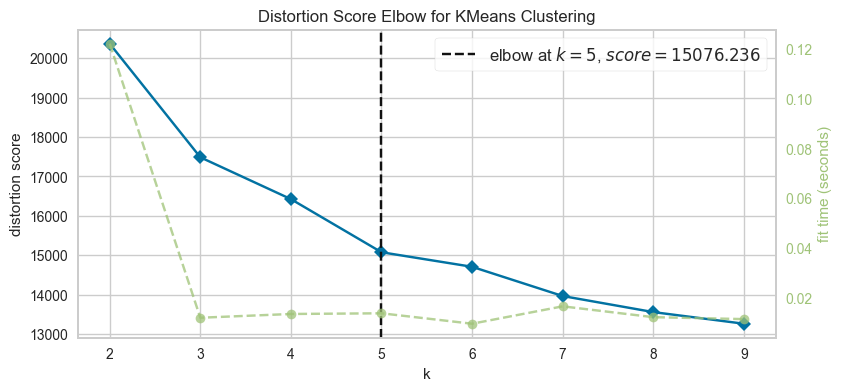

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# Ascertain Optimal Number of Clusters 

from yellowbrick.cluster import KElbowVisualizer

plt.figure(figsize = (9, 4))
# Instantiate the clustering model and visualizer
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(data_)
visualizer.show()  

In [239]:
kmeans_data_original = data_.copy()

km = KMeans(n_clusters = 5,
            init = 'k-means++', 
            n_init = 10,
            max_iter = 100, 
            random_state = 45)

clusters_predict = km.fit_predict(kmeans_data_original)
kmeans_data_original['Clusters'] = clusters_predict
kmeans_data_original.head()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Clusters
0,-1.039059,0.494940,-0.904198,-1.011050,0.387310,1.134374,1.532832,1.575426,1.745676,1.522403,1.193204,0.772749,1.393135,1.877167,-0.336513,0.683902,0
1,-1.281233,-0.052175,1.068605,0.923399,-0.278458,-1.195321,-0.953409,-1.415123,-0.826732,-0.931255,-0.939690,0.143138,-1.395621,-0.298107,-1.668177,-0.289033,2
2,-0.369288,1.042068,-0.904198,-1.011050,-0.724794,0.825165,1.181231,0.573991,1.464486,0.666176,0.520879,-1.038531,1.393135,0.264347,1.308691,-0.737378,1
3,1.370030,-1.202635,1.068605,-1.011050,-0.724794,-1.195321,-0.314810,-0.665457,-0.014486,-0.452057,-1.050786,0.143138,-0.718963,-1.331966,-0.336513,0.185579,3
4,1.080809,0.501654,1.068605,-1.011050,1.443123,0.199296,1.102073,0.523851,0.906784,0.817705,-0.310627,1.442190,0.562922,0.645595,0.420663,-0.289033,0


In [240]:
print(f"Davies bouldin score: {davies_bouldin_score(kmeans_data_original,kmeans_data_original['Clusters'])}")
print(f"Calinski Score: {calinski_harabasz_score(kmeans_data_original,kmeans_data_original['Clusters'])}")
print(f"Silhouette Score: {silhouette_score(kmeans_data_original,kmeans_data_original['Clusters'])}")

Davies bouldin score: 1.741030512808451
Calinski Score: 687.8481348372563
Silhouette Score: 0.20881499899190586


The metrics above point to a sub-optimal clustering solution since they fail to demonstrate a distinct separation between the various clusters.<br>
This limitation is perhaps related to the noise in the data, which makes it Kmeans algorithm incapable of capturing complicated relationships.<br>
As a result, it is necessary to use dimensionality reduction techniques that could reduce the noise in the data.<br>

<h3 style = "color:#FF2171"><b><center>PCA DIMENSIONALITY REDUCTION</b></h3></center><hr style = "width:400px;text-align:center;color:#EDB7ED">

In [241]:
# Dimensionality Reduction with Principal Component Analysis 

# In this program, you can either pass the number of features(num_compnents) you want to be returned, 
# or the number of information (percentage_info) you want to be captured from the original dataset.

def dimensionReduce(features, percentage_info = None, num_components = None, plot_scree = False):
    from sklearn.decomposition import PCA # ............................. Import the PCA Algorithm

    if num_components != None:
        x_pca = features # .................................................. Select the features to be Decomposed
        pca = PCA(n_components = num_components) # ........................... Instantiate PCA, and amount of information to be captured
        pca.fit(x_pca) # .................................................... Fit the PCA Algorithm on the selected features
        x_pca = pca.transform(x_pca) # ...................................... Transform the data 
        frame_x_pca = pd.DataFrame(x_pca, columns= ['Decompose' + str(i + 1) for i in range(num_components)])

    if percentage_info != None:
        x_pca = features # .................................................. Select the features to be Decomposed
        pca = PCA(n_components = percentage_info) # ........................... Instantiate PCA, and amount of information to be captured
        pca.fit(x_pca) # .................................................... Fit the PCA Algorithm on the selected features
        num_components = len(pca.explained_variance_ratio_)
        x_pca = pca.transform(x_pca) # ...................................... Transform the data 
        frame_x_pca = pd.DataFrame(x_pca, columns= ['Decompose' + str(i + 1) for i in range(num_components)])

    # Find out how much information in the original dataset this dimensionality reduction covers
    cumulative_variance = pca.explained_variance_ratio_
    print(f"Cumulative Variance is :\n {cumulative_variance}")

    # Show the total variance explained by the newly created features
    print(f"\nTotal information captured: \n{sum([i for i in cumulative_variance])}")

    if plot_scree == True:
        # Plot the Scree Plot to show the feature information 
        sns.set(style = 'darkgrid')
        fig, ax = plt.subplots(figsize=(7, 3))
        ax.bar(range(1, int(x_pca.shape[1]) + 1), pca.explained_variance_ratio_)
        ax.plot(range(1, int(x_pca.shape[1]) +1), cumulative_variance, 'o-', color='r')
        plt.xlabel('Principal component')
        plt.ylabel('Proportion of variance explained')
        plt.title('Histogram scree plot')

    return frame_x_pca


# We reduce the dimensionality of only the numerical features
pca_data = dimensionReduce(data_, percentage_info = 0.95)
pca_data.head()

Cumulative Variance is :
 [0.45099602 0.12975845 0.09166325 0.06277377 0.04765433 0.04097746
 0.03332673 0.02963533 0.02276291 0.02112253 0.0203914 ]

Total information captured: 
0.9510621957582005


,Decompose1,Decompose2,Decompose3,Decompose4,Decompose5,Decompose6,Decompose7,Decompose8,Decompose9,Decompose10,Decompose11
0,-3.732817,-0.061891,1.497788,-0.531669,-1.190764,-1.399430,0.888266,0.046810,-0.003415,0.357427,-0.333270
1,2.966606,0.729207,-1.613314,0.109337,-0.997096,0.593499,0.548620,-1.028167,0.217178,0.258704,-0.249060
2,-3.078291,-1.154268,-0.149199,0.796260,-0.013716,-0.550293,0.581053,0.653330,0.145189,-0.449935,-0.244866
3,2.648821,-1.240036,1.086878,0.728550,0.155134,0.785272,0.174538,0.509941,-0.508594,-0.363772,-0.039816
4,-1.283057,-0.541977,1.963815,-1.500289,0.314507,1.437932,0.862351,0.166320,-0.247663,-0.299138,0.093936


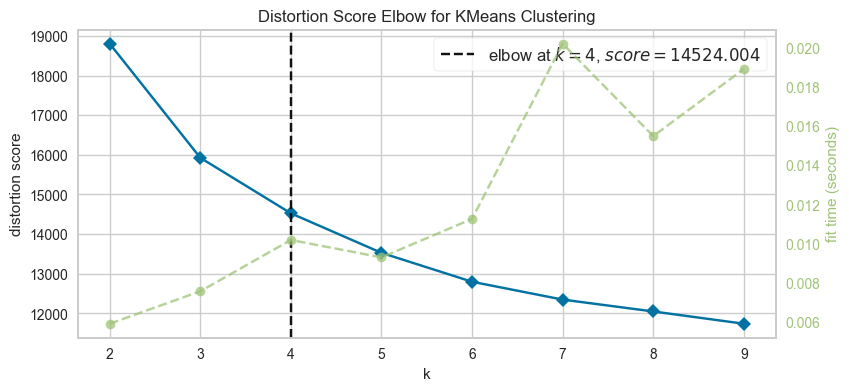

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
# Ascertain Optimal Number of Clusters 

from yellowbrick.cluster import KElbowVisualizer

plt.figure(figsize = (9, 4))
# Instantiate the clustering model and visualizer
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(pca_data)
visualizer.show()  

In [242]:
kmeans_pca_data = pca_data.copy()

km = KMeans(n_clusters = 4,
            init = 'k-means++', 
            n_init = 10,
            random_state = 45)

clusters_predict = km.fit_predict(kmeans_pca_data)
kmeans_pca_data['Clusters'] = clusters_predict
kmeans_pca_data.head()

,Decompose1,Decompose2,Decompose3,Decompose4,Decompose5,Decompose6,Decompose7,Decompose8,Decompose9,Decompose10,Decompose11,Clusters
0,-3.732817,-0.061891,1.497788,-0.531669,-1.190764,-1.399430,0.888266,0.046810,-0.003415,0.357427,-0.333270,3
1,2.966606,0.729207,-1.613314,0.109337,-0.997096,0.593499,0.548620,-1.028167,0.217178,0.258704,-0.249060,0
2,-3.078291,-1.154268,-0.149199,0.796260,-0.013716,-0.550293,0.581053,0.653330,0.145189,-0.449935,-0.244866,3
3,2.648821,-1.240036,1.086878,0.728550,0.155134,0.785272,0.174538,0.509941,-0.508594,-0.363772,-0.039816,2
4,-1.283057,-0.541977,1.963815,-1.500289,0.314507,1.437932,0.862351,0.166320,-0.247663,-0.299138,0.093936,1


In [243]:
print(f"Davies bouldin score: {davies_bouldin_score(kmeans_pca_data,kmeans_pca_data['Clusters'])}")
print(f"Calinski Score: {calinski_harabasz_score(kmeans_pca_data,kmeans_pca_data['Clusters'])}")
print(f"Silhouette Score: {silhouette_score(kmeans_pca_data,kmeans_pca_data['Clusters'])}")

Davies bouldin score: 1.45616946140496
Calinski Score: 826.376950094614
Silhouette Score: 0.25523387388363494


To visually represent our clusters, we will further reduce the dimension of our data to 3 and to 2 for ease of visulization.<br>
To do this, we will be making use of the t-Distributed Stochastic Neighbour Embedding (t-SNE) technique.<br><br>
Here is a little about the t-sne:<br>
t-SNE (t-distributed Stochastic Neighbor Embedding) is an unsupervised non-linear <br>
dimensionality reduction technique for data exploration and visualizing high-dimensional data.<br> 
Non-linear dimensionality reduction means that the algorithm allows us to separate data that cannot be separated by a straight line. <br> 
T-SNE excels at capturing the local structure and relationships within the data, <br>
making it particularly effective at revealing clusters and patterns that 
might be difficult to discern in the original high-dimensional space. <br> 
By focusing on preserving local relationships, T-SNE can provide insights into the underlying 
data distribution and enable a better understanding of complex data structures. <br> 
However, it is essential to note that T-SNE is primarily used for visualization and 
exploration rather than capturing the global variance within the dataset.

<h3 style = "color:#FF2171"><b><center>t-Distributed Stochastic Neighbour Embedding (t-SNE)</b></h3></center><hr style = "width:400px;text-align:center;color:#EDB7ED">

Checking Perplexity vs. Divergence<br>

For the t-SNE algorithm, perplexity is a very important hyperparameter.<br>
It controls the effective number of neighbors that each point considers during the dimensionality reduction process. 

We will run a loop to get the KL Divergence metric on various perplexities from 5 to 55 with 5 points gap. <br>
After that, we will display the result using the Plotly Express line plot.

In [51]:
from sklearn.manifold import TSNE

perplexity = np.arange(5, 205, 5)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = model.fit_transform(pca_data)
    divergence.append(model.kl_divergence_)
fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()

In the context of t-SNE, the KL divergence is used as a measure of the difference <br>
between the original high-dimensional data and the lower-dimensional representation created by t-SNE. <br>
The lower the KL divergence, the better the model, as it suggests that the lower-dimensional <br>
representation is effectively capturing the local structure of the original data. <br>
Therefore, a lower divergence score is indicative of a better t-SNE model.

In [108]:
# if a perplexity of 200 gives a divergence of 37%, then a slightly higher perplexity should give a better divergence  

def stochasticNeighbour(data, num_components):
    df_tSNE = TSNE(
                    n_components = num_components, 
                    learning_rate = 500, 
                    init = 'random', 
                    perplexity = 270, 
                    n_iter = 5000).fit_transform(data)
    df_tSNE = pd.DataFrame(df_tSNE, columns=["Decompose" + str(_+ 1) for _ in range(num_components)])
    return df_tSNE

In [100]:
# Creating a Function for 3D or 2D visuals for metrics 

def plotter(df, expected_features=3, opacity=0.8, width_line=0.1):
    df = df.astype({"Clusters": "object"})
    df = df.sort_values("Clusters")

    if expected_features == 3:
        fig = px.scatter_3d(
            df,
            x='Decompose1',
            y='Decompose2',
            z='Decompose3',
            color='Clusters',
            template="plotly",
            color_discrete_sequence=px.colors.qualitative.Vivid,
            title = f"{expected_features}D PCA SPACE"
        )
        fig.update_traces(
            marker={
                "size": 4,
                "opacity": opacity,
                "line": {
                    "width": width_line,
                    "color": "black",
                }
            }
        ).update_layout(
            width=1300,
            height =800,
            autosize=True,
            showlegend=True
        )
        
    elif expected_features == 2:
        fig = px.scatter(
            df,
            x='Decompose1',
            y='Decompose2',
            color='Clusters',
            template="plotly",
            color_discrete_sequence=px.colors.qualitative.Vivid,
            title = f"{expected_features}D PCA SPACE"
        )

    fig.show()

In [111]:
# create 2d and 3d dimension data with t-sne reduction function

visual_tSNE_3D = stochasticNeighbour(pca_data, 3) # ........ For 3 dimensional Visuals
visual_tSNE_2D = stochasticNeighbour(pca_data, 2) # ........ For 2 dimensional Visuals

print(f'3D Dimension Data')
display(visual_tSNE_3D.head())

print(f'2D Dimension Data')
display(visual_tSNE_2D.head())

3D Dimension Data


,Decompose1,Decompose2,Decompose3
0,1.943822,1.223357,6.188507
1,0.653775,-1.199436,-4.455322
2,0.779415,-0.034311,7.524411
3,-3.684151,1.948892,-5.334533
4,-5.867971,-0.218724,-1.085010


2D Dimension Data


,Decompose1,Decompose2
0,-10.480293,4.698263
1,5.171204,-5.614054
2,-12.096702,3.210163
3,9.613071,0.695832
4,-5.190074,-2.630733


In [115]:
kmeans_tsne_3D_visuals = visual_tSNE_3D.copy()

kmeans_tsne_3D_visuals['Clusters'] = clusters_predict
plotter(kmeans_tsne_3D_visuals, opacity=0.8, width_line = 0.1)

In [117]:
kmeans_tsne_2D_visuals = visual_tSNE_2D.copy()

kmeans_tsne_2D_visuals['Clusters'] = clusters_predict
plotter(kmeans_tsne_2D_visuals, expected_features= 2,  opacity=0.8, width_line = 0.1)

From the above metrics, there is a slight difference between the performance of the reduced dimension data and the original data. <br>
Although the difference is not enough to build an actual model on, hence the need to explore other options of technicalities to achieve a more optimal result.

<h3 style = "color:#FF2171"><b><center>GUASSIAN MIXTURE MODEL</b></h3></center><hr style = "width:400px;text-align:center;color:#EDB7ED">

The Gaussian Mixture Model (GMM) is a probabilistic model used for clustering and density estimation. <br>
It assumes that the data points are generated from a mixture of several Gaussian distributions, each representing a cluster. <br>
GMM estimates the parameters of these Gaussians to identify the underlying clusters and their corresponding probabilities, <br>
allowing it to handle complex data distributions and overlapping clusters.
<b><i><p style = 'text-align: right; font-size: 10px; color:#F1B4BB'>Gotten From Analytics Vidhya</p>

We try the algorithm firstly on the original data and compare its performance with the dimensionally reduced data.


In [12]:
# On the Original Data 
gmm_data_original = data_.copy()

gmm = GaussianMixture(n_components = 5, init_params= 'k-means++', verbose=2)
gmm.fit(gmm_data_original)

soft_clusters = gmm.predict(gmm_data_original)

probs = gmm.predict_proba(gmm_data_original)

# Set the threshold for cluster assignment
threshold = 0.8

# Convert soft clustering to hard clustering based on the threshold
hard_clusters = np.zeros(len(gmm_data_original), dtype=int)  # Initialize the array for hard clustering

for i in range(len(gmm_data_original)):
    max_prob = np.max(probs[i])
    if max_prob >= threshold:
        hard_clusters[i] = np.argmax(probs[i])

gmm_data_original['Hard Clusters'] = hard_clusters
gmm_data_original['soft_clusters'] = soft_clusters

# confirm there is a difference between the two clusters 
from sklearn.metrics import r2_score
print(f"\n\nPercentage similarities between the clusters: \n\t{r2_score(gmm_data_original['soft_clusters'], gmm_data_original['Hard Clusters'])}")

gmm_data_original

Initialization 0
  Iteration 10	 time lapse 0.07435s	 ll change 1.86096
Initialization converged: True	 time lapse 0.09990s	 ll -6.61258


Percentage similarities between the clusters: 
	0.9805583794619527


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Hard Clusters,soft_clusters
0,-1.039059,0.494940,-0.904198,-1.011050,0.387310,1.134374,1.532832,1.575426,1.745676,1.522403,1.193204,0.772749,1.393135,1.877167,-0.336513,0.683902,2,2
1,-1.281233,-0.052175,1.068605,0.923399,-0.278458,-1.195321,-0.953409,-1.415123,-0.826732,-0.931255,-0.939690,0.143138,-1.395621,-0.298107,-1.668177,-0.289033,1,1
2,-0.369288,1.042068,-0.904198,-1.011050,-0.724794,0.825165,1.181231,0.573991,1.464486,0.666176,0.520879,-1.038531,1.393135,0.264347,1.308691,-0.737378,2,2
3,1.370030,-1.202635,1.068605,-1.011050,-0.724794,-1.195321,-0.314810,-0.665457,-0.014486,-0.452057,-1.050786,0.143138,-0.718963,-1.331966,-0.336513,0.185579,3,3
4,1.080809,0.501654,1.068605,-1.011050,1.443123,0.199296,1.102073,0.523851,0.906784,0.817705,-0.310627,1.442190,0.562922,0.645595,0.420663,-0.289033,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,-0.196250,0.626561,-0.904198,0.923399,-0.002716,1.223478,1.102073,0.820001,0.849948,1.693856,2.236588,0.143138,1.619322,0.645595,-0.336513,-0.289033,0,0
1990,-1.903961,0.742176,1.739011,0.923399,0.323986,0.789301,-1.453811,-0.399030,-1.504816,-1.425288,-0.754474,1.798879,1.393135,0.264347,0.084674,0.683902,1,1
1991,1.080809,0.444473,-0.904198,-1.011050,1.360105,1.429554,1.168751,0.940554,0.681130,0.329986,0.053550,-1.038531,-0.718963,0.645595,1.728743,0.185579,2,2
1992,-1.120319,0.950804,-0.904198,0.923399,-1.530754,0.828674,0.882931,0.931006,1.255760,0.881177,0.852357,0.143138,0.871194,1.159001,1.308691,-1.156065,0,0


there is similarity between hard clustering and soft clustering of the data points

In [13]:
# Metrics oif the Gaussian Mixture Model
print('METRICS FOR THE GAUSSIAN MIXTURE MODEL ORIGINAL DATA:')
print(f"\t Davies bouldin score: {davies_bouldin_score(gmm_data_original,gmm_data_original['soft_clusters'])}")
print(f"\t Calinski Score: {calinski_harabasz_score(gmm_data_original,gmm_data_original['soft_clusters'])}")
print(f"\t Silhouette Score: {silhouette_score(gmm_data_original,gmm_data_original['soft_clusters'])}")

METRICS FOR THE GAUSSIAN MIXTURE MODEL ORIGINAL DATA:
	 Davies bouldin score: 1.510049946702162
	 Calinski Score: 506.28772605499523
	 Silhouette Score: 0.2330313025846311


In [50]:
# On the Original Data 
gmm_data_pca = pca_data.copy()

gmm = GaussianMixture(n_components = 5, init_params= 'k-means++', verbose=2)
gmm.fit(gmm_data_pca)

soft_clusters = gmm.predict(gmm_data_pca)

probs = gmm.predict_proba(gmm_data_pca)

# Set the threshold for cluster assignment
threshold = 0.8

# Convert soft clustering to hard clustering based on the threshold
hard_clusters = np.zeros(len(gmm_data_pca), dtype=int)  # Initialize the array for hard clustering

for i in range(len(gmm_data_pca)):
    max_prob = np.max(probs[i])
    if max_prob >= threshold:
        hard_clusters[i] = np.argmax(probs[i])

gmm_data_pca['Hard Clusters'] = hard_clusters
gmm_data_pca['soft_clusters'] = soft_clusters

# confirm there is a difference between the two clusters 
from sklearn.metrics import r2_score
print(f"\n\nPercentage similarities between the clusters: \n\t{r2_score(gmm_data_pca['soft_clusters'], gmm_data_pca['Hard Clusters'])}")

gmm_data_pca

Initialization 0
  Iteration 10	 time lapse 0.05028s	 ll change 0.00380
Initialization converged: True	 time lapse 0.09276s	 ll -11.53827


Percentage similarities between the clusters: 
	0.8622787707727629


,Decompose1,Decompose2,Decompose3,Decompose4,Decompose5,Decompose6,Decompose7,Decompose8,Decompose9,Decompose10,Decompose11,Hard Clusters,soft_clusters
0,-3.732817,-0.061891,1.497788,-0.531669,-1.190764,-1.399430,0.888266,0.046810,-0.003415,0.357427,-0.333270,4,4
1,2.966606,0.729207,-1.613314,0.109337,-0.997096,0.593499,0.548620,-1.028167,0.217178,0.258704,-0.249060,1,1
2,-3.078291,-1.154268,-0.149199,0.796260,-0.013716,-0.550293,0.581053,0.653330,0.145189,-0.449935,-0.244866,2,2
3,2.648821,-1.240036,1.086878,0.728550,0.155134,0.785272,0.174538,0.509941,-0.508594,-0.363772,-0.039816,1,1
4,-1.283057,-0.541977,1.963815,-1.500289,0.314507,1.437932,0.862351,0.166320,-0.247663,-0.299138,0.093936,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,-3.305244,0.523866,0.785573,-0.071360,-0.922090,-0.626709,-1.081269,-0.629615,1.002502,0.655165,-0.163355,0,0
1990,0.933533,3.757334,-0.342106,-0.374400,0.893745,0.109671,2.104820,-0.594425,-0.061289,0.201314,0.307882,3,3
1991,-2.175580,-1.603275,0.161692,-1.166997,1.268024,-0.154263,-0.219877,0.822556,-0.073381,-0.724841,0.201294,2,2
1992,-3.517727,0.597543,-0.706044,1.455500,-0.990066,0.385584,-0.010460,-0.073509,-0.173152,-0.009400,-0.228538,0,0


In [51]:
# Metrics oif the Gaussian Mixture Model
print('METRICS FOR THE GAUSSIAN MIXTURE MODEL ON PCA DATA:')
print(f"\t Davies bouldin score: {davies_bouldin_score(gmm_data_pca,gmm_data_pca['Hard Clusters'])}")
print(f"\t Calinski Score: {calinski_harabasz_score(gmm_data_pca,gmm_data_pca['Hard Clusters'])}")
print(f"\t Silhouette Score: {silhouette_score(gmm_data_pca,gmm_data_pca['Hard Clusters'])}")

METRICS FOR THE GAUSSIAN MIXTURE MODEL ON PCA DATA:
	 Davies bouldin score: 1.5460482393617192
	 Calinski Score: 527.3714618771762
	 Silhouette Score: 0.2561234195358971


In [101]:
visual_gmm = gmm_data_pca.drop(['Hard Clusters', 'soft_clusters'], axis = 1)
visual_gmm_3D = dimensionReduce(visual_gmm, num_components= 3)
visual_gmm_3D['Clusters'] = gmm_data_pca['Hard Clusters']
plotter(visual_gmm_3D, 3)

Cumulative Variance is :
 [0.47420245 0.13643529 0.09637987]

Total information captured: 
0.7070176087830544


In [118]:
visual_gmm = gmm_data_pca.drop(['Hard Clusters', 'soft_clusters'], axis = 1)
visual_gmm_2D = dimensionReduce(visual_gmm, num_components= 2)
visual_gmm_2D['Clusters'] = gmm_data_pca['Hard Clusters']
plotter(visual_gmm_3D, 2)

Cumulative Variance is :
 [0.47420245 0.13643529]

Total information captured: 
0.6106377349799696


<h3 style = "color:#FF2171"><b><center>BIRCH</b></h3></center><hr style = "width:400px;text-align:center;color:#EDB7ED">

BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies) is a hierarchical clustering algorithm <br>
that aims to provide a scalable and memory-efficient method for clustering large datasets. <br>
The algorithm creates a summary of the dataset by grouping similar observations <br>
(measured as euclidean distance) and providing a summary of the retained information.
At a high level, Balanced Iterative Reducing and Clustering using Hierarchies, <br>
or BIRCH for short, deals with large datasets by first generating a more compact summary that retains as much distribution <br>
information as possible, and then clustering the data summary instead of the original dataset. <br>
BIRCH actually complements other clustering algorithms by virtue if the fact that different <br>
clustering algorithms can be applied to the summary produced by BIRCH<br><br>
The threshold is an important parameter, we can create a iteration that tries possible numbers of threshold and returns the best.

Text(0.5, 1.0, 'Threshold and Davies Boulden Score')

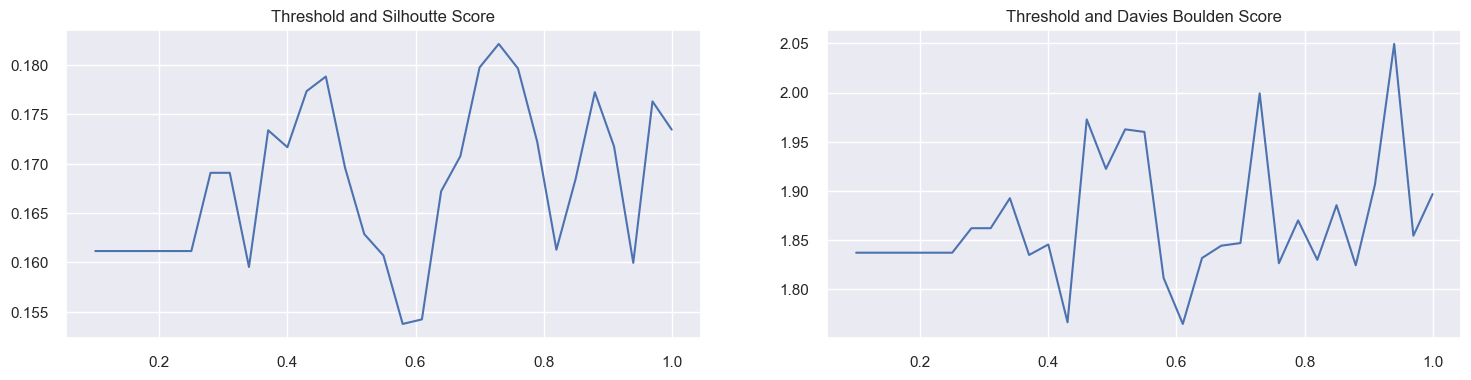

In [90]:
#                                           -- Run a loop to ascertain the best threshold for the algorithm --
birch_data = pca_data.copy()

silhoutte = []
davies_B = []
threshold = []

for _ in np.arange(0.1, 1, 0.03):
    brc = Birch(n_clusters = 4, threshold = _)
    clust = brc.fit_predict(pca_data)
    threshold.append(_)
    silhoutte.append(silhouette_score(birch_data, clust))
    davies_B.append(davies_bouldin_score(birch_data, clust))

plt.figure(figsize = (18,4))
sns.set(style = 'darkgrid')

plt.subplot(1, 2, 1)
sns.lineplot(x = threshold, y = silhoutte)
plt.title('Threshold and Silhoutte Score')

plt.subplot(1, 2, 2)
sns.lineplot(x = threshold, y = davies_B)
plt.title('Threshold and Davies Boulden Score')
# preds = clusters = brc.predict(pca_data)

# birch_data['Clusters'] = preds
# birch_data

In [93]:
# Having ascertain the best threshold value is 0.42, then we use this threshold to create the algorithm
# Also, Its been established that there is no significant score diffeence in modelling with the PCA data and original data

brc = Birch(n_clusters = 4, threshold = 0.42)
brc.fit(pca_data)
brc_cluster = brc.predict(birch_data)
birch_data['Clusters'] = brc_cluster
birch_data.head()

,Decompose1,Decompose2,Decompose3,Decompose4,Decompose5,Decompose6,Decompose7,Decompose8,Decompose9,Decompose10,Decompose11,Clusters
0,-3.732817,-0.061891,1.497788,-0.531669,-1.190764,-1.399430,0.888266,0.046810,-0.003415,0.357427,-0.333270,0
1,2.966606,0.729207,-1.613314,0.109337,-0.997096,0.593499,0.548620,-1.028167,0.217178,0.258704,-0.249060,3
2,-3.078291,-1.154268,-0.149199,0.796260,-0.013716,-0.550293,0.581053,0.653330,0.145189,-0.449935,-0.244866,0
3,2.648821,-1.240036,1.086878,0.728550,0.155134,0.785272,0.174538,0.509941,-0.508594,-0.363772,-0.039816,1
4,-1.283057,-0.541977,1.963815,-1.500289,0.314507,1.437932,0.862351,0.166320,-0.247663,-0.299138,0.093936,0


In [94]:
# Metrics oif the Gaussian Mixture Model
print('METRICS FOR THE GAUSSIAN MIXTURE MODEL ON PCA DATA:')
print(f"\t Davies bouldin score: {davies_bouldin_score(birch_data,birch_data['Clusters'])}")
print(f"\t Calinski Score: {calinski_harabasz_score(birch_data,birch_data['Clusters'])}")
print(f"\t Silhouette Score: {silhouette_score(birch_data,birch_data['Clusters'])}")

METRICS FOR THE GAUSSIAN MIXTURE MODEL ON PCA DATA:
	 Davies bouldin score: 1.4698365708533239
	 Calinski Score: 736.0447220851125
	 Silhouette Score: 0.23689703899422215


In [120]:
# Create visuals for the birch model using the TSNE

birch_tsne_3D_visuals = visual_tSNE_3D.copy()
birch_tsne_3D_visuals['Clusters'] = brc_cluster
plotter(birch_tsne_3D_visuals, expected_features= 3, opacity=0.8, width_line = 0.1)

In [122]:
birch_tsne_2D_visuals = visual_tSNE_2D.copy()
birch_tsne_2D_visuals['Clusters'] = brc_cluster
plotter(birch_tsne_2D_visuals, expected_features= 2, opacity=0.8, width_line = 0.1)

Thus far, the best model we have been able to generate is the BIRCH model with a score of:
<ul>
<li>Silhoutte Score: 0.23689703899422215</li>
<li>Davies bouldin score: 1.4698365708533239</li>
<li>Calinski Score: 736.0447220851125</li>
</ul>
It is as well good to note that a model is as good as the data that was used in training it.

<h3 style = "color:#FF2171"><b><center>MODEL INTERPETATION</b></h3></center><hr style = "width:400px;text-align:center;color:#EDB7ED">

Finally we must analyze the characteristics of the clusters. This part of the study is what is decisive for the business. <br>
For them we are going to obtain the means (for the numerical variables) and the most frequent value (categorical variables) <br>
of each of the features of the dataset for each of the clusters:

In [125]:
final_data = removed_outlier.drop('index', axis = 1).copy()
final_data['Clusters'] = brc_cluster
final_data

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Clusters
0,5524,1957,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0
1,2174,1954,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,3
2,4141,1965,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0
3,6182,1984,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,1
4,5324,1981,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,10870,1967,61223.0,0,1,46,709,43,182,42,118,247,2,9,3,4,5,0
1990,4001,1946,64014.0,2,1,56,406,0,30,0,0,8,7,8,2,5,7,2
1991,7270,1981,56981.0,0,0,91,908,48,217,32,12,24,1,2,3,13,6,0
1992,8235,1956,69245.0,0,1,8,428,30,214,80,30,61,2,6,5,10,3,0


In [218]:
# Analysing the charactericstics of each cluster group 

common_factors = final_data.groupby('Clusters').agg(
    {
        'Income': 'median',
        'Kidhome': 'mean',
        'Teenhome': 'mean',
        'MntWines': 'median',
        'MntFruits': 'median',
        'MntMeatProducts': 'median',
        'MntFishProducts':'median',
        'NumWebPurchases': 'median',
        'NumCatalogPurchases': 'median',
        'NumWebVisitsMonth': 'median',
        'NumStorePurchases': 'median',
    }
)
common_factors

,Income,Kidhome,Teenhome,MntWines,MntFruits,MntMeatProducts,MntFishProducts,NumWebPurchases,NumCatalogPurchases,NumWebVisitsMonth,NumStorePurchases
Clusters,,,,,,,,,,,
0,69174.0,0.085165,0.476648,477.5,35.0,251.0,55.0,5.0,4.0,3.0,8.0
1,28118.0,0.826180,0.012876,10.0,3.0,13.0,4.0,2.0,0.0,7.0,3.0
2,50272.0,0.469548,0.807466,215.0,5.0,60.0,7.0,5.0,2.0,7.0,5.0
3,38578.0,0.869416,1.027491,24.0,1.0,10.0,2.0,2.0,0.0,6.0,3.0


In [219]:
# We cant make good interpretation of the Kidhome and Teenhome, hence we convert it to integer using a threshold of 0.5

for i in common_factors.columns:
    common_factors[i] = common_factors[i].astype(float) # .............................. Turn the columns to float from string
    if common_factors[i].mean() < 1.1: # ............................................... Select the kindhome and teenhome (columns having mean below 1)
        common_factors[i + str('_')] = (common_factors[i] > 0.5).astype(int) # ......... Create a new column, enter 1 if the value is more than 0.5

        common_factors.drop(i, axis = 1, inplace = True) # ............................. Drop the kidhome and teenhome column that has been worked on
    else:
        common_factors[i] = common_factors[i].astype(int) # ............................ Turn the cother columns to integer

common_factors

,Income,MntWines,MntFruits,MntMeatProducts,MntFishProducts,NumWebPurchases,NumCatalogPurchases,NumWebVisitsMonth,NumStorePurchases,Kidhome_,Teenhome_
Clusters,,,,,,,,,,,
0,69174,477,35,251,55,5,4,3,8,0,0
1,28118,10,3,13,4,2,0,7,3,1,0
2,50272,215,5,60,7,5,2,7,5,0,1
3,38578,24,1,10,2,2,0,6,3,1,1


In [229]:
# Create a function that calculates the total average purchases made by each clusters 

def average_purchases(data):
    sum_average_purchases = []

    for i in range(len(data.index)):
        sum_average_purchases.append(np.sum(data.drop(['Income', 'Kidhome_', 'Teenhome_'], axis = 1).iloc[i, :].values))
        
    return pd.DataFrame(sum_average_purchases, columns = ['Total Average Purchases'])  


avg_purchase = average_purchases(common_factors)
avg_purchase['Income'] = common_factors['Income']
avg_purchase['Children Present'] = common_factors['Kidhome_'] + common_factors['Teenhome_']
avg_purchase.index.name = 'Cluster'
avg_purchase

,Total Average Purchases,Income,Children Present
Cluster,,,
0,838,69174,0
1,42,28118,1
2,306,50272,1
3,48,38578,2


<ul>
<li>Cluster Class 0: This is the cluster of customers who earn the highest income at an average of $69200, <br>
have an average of no kid at home, and makes the most purchases at an average of 838 purchases annually.</li>
<li>Cluster Class 1: This is the cluster of customers who earn the lowest income at an average of $30000, <br>
have an average of just one kid at home and makes the least purchases at an average of 42 purchases annually.
</li>
<li>Cluster Class 2: This is cluster of customers who earn high income and makes average of 306 purchases annually, <br>
and have an average of 1 child at home</li>
<li>Cluster Class 3: This is the cluster of customer who earns a low income at an average of $38600 annually, <br>
has an average of two children at home, and also makes an average of 48 purchases annually. </li>
</ul>

<h3 style = "color:#FF2171"><b><center>END</b></h3></center><hr style = "width:400px;text-align:center;color:#EDB7ED">